In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
from matplotlib import pyplot as plt
from PIL import Image
import os
import RGBHSL
import time

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [57]:
locloc = "BigDataCubes" 
namename = "\CombinedDatasets\Part0"
all_photos = np.load(locloc + namename + 'Photos.npy')[0:1700]
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
all_albedos = np.load(locloc + namename + 'Albedos.npy')[0:1700]
#all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')[0:1700,:,:,0]
# Цель просто сделать рабочий генератор маски.
all_differences = np.zeros(all_photos.shape)

In [78]:
def normalizeNegativeImage(imim, mask):
    mask = np.stack([mask, mask, mask], axis=2)
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nmax = 0.01
    if nonneg.max() != 0:
        nmax = nonneg.max()
    nonneg = nonneg * (1.0/nmax)
    return nonneg * mask

In [223]:
all_photos = np.load(locloc + "\CombinedDatasets" + "\SmallHSL" + "Photo.npy")
all_albedos = np.load(locloc + "\CombinedDatasets" + "\SmallHSL" + "Albedo.npy")

In [224]:
all_differences = (all_photos - all_albedos)[:, :, :, 1:3]

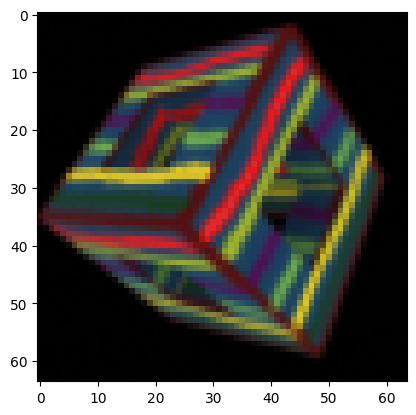

In [231]:
plt.imshow(RGBHSL.image_coverter( all_photos[2] - np.stack([np.zeros((64,64)), all_differences[2, :,:,0],all_differences[2, :,:,1]], axis=2)
                                 , RGBHSL.pixel_hsl_to_rgb, normalized_input=True, normalize_output=True))

In [76]:
"""
prevtime = time.time()
for photo in range(len(all_photos)):
    all_photos[photo] = RGBHSL.image_coverter(all_photos[photo],RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)
    all_albedos[photo] = RGBHSL.image_coverter(all_albedos[photo],RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)
    if photo % 100 == 0: 
        nowtime = time.time()
        seconds, milliseconds = divmod((nowtime - prevtime) * 1000, 1000)
        prevtime = nowtime
        print(f"{photo // 100}00 сек {seconds} мсек {milliseconds}")
print("finished")
"""

'\nprevtime = time.time()\nfor photo in range(len(all_photos)):\n    all_photos[photo] = RGBHSL.image_coverter(all_photos[photo],RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)\n    all_albedos[photo] = RGBHSL.image_coverter(all_albedos[photo],RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)\n    if photo % 100 == 0: \n        nowtime = time.time()\n        seconds, milliseconds = divmod((nowtime - prevtime) * 1000, 1000)\n        prevtime = nowtime\n        print(f"{photo // 100}00 сек {seconds} мсек {milliseconds}")\nprint("finished")\n'

In [77]:
"""
np.save(locloc + "\CombinedDatasets" + "\SmallHSL" + "Photo", all_photos)
np.save(locloc + "\CombinedDatasets" + "\SmallHSL" + "Albedo", all_albedos)
"""

'\nnp.save(locloc + "\\CombinedDatasets" + "\\SmallHSL" + "Photo", all_photos)\nnp.save(locloc + "\\CombinedDatasets" + "\\SmallHSL" + "Albedo", all_albedos)\n'

In [121]:
myHSL_Photo = RGBHSL.image_coverter(all_photos[0], RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)
myHSL_Albedo = RGBHSL.image_coverter(all_albedos[0], RGBHSL.pixel_rgb_to_hsl, normalized_input= True,  normalize_output=True)
myHSL_Diff = (myHSL_Photo - myHSL_Albedo)
myHSL_Diff[:,:,0] = np.zeros((64,64))

In [122]:
myRGB_Photo = RGBHSL.image_coverter(myHSL_Photo, RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)
myRGB_Albedo = RGBHSL.image_coverter(myHSL_Albedo, RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)
myRGB_Diff = RGBHSL.image_coverter(np.clip(myHSL_Photo - myHSL_Diff, 0, 1), RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)

In [123]:
myHSL_Diff_norm = normalizeNegativeImage(myHSL_Diff, np.zeros((64,64)) + 1)
myHSL_Diff_norm = np.clip(myHSL_Diff_norm, 0, 1)
#myRGB_Diff_norm = RGBHSL.image_coverter(myHSL_Diff_norm, RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)

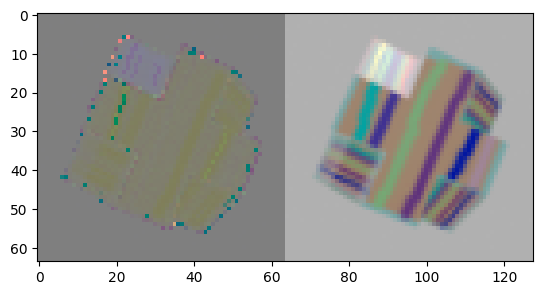

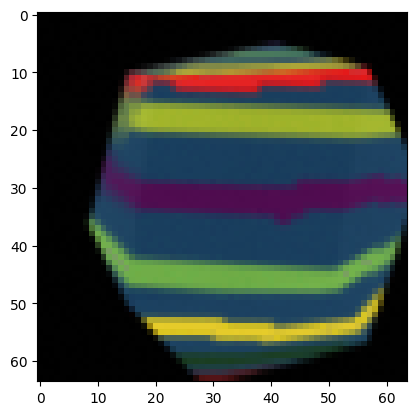

In [194]:
ans = all_photos[5] - np.stack([np.zeros((64,64)), all_differences[5,:,:,0], all_differences[5,:,:,1]], axis = 2)
ans = RGBHSL.image_coverter(ans, RGBHSL.pixel_hsl_to_rgb, normalized_input= True,  normalize_output=True)
plt.imshow(ans)

In [131]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_differences))

dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape), print(all_differences.shape)

(1700, 64, 64, 3)
(1700, 64, 64, 2)


(None, None)

In [155]:
#4,592,758 | 4,592,721
def GiveModel(dropout = 0.4):
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(x)
    do = keras.layers.Dropout(dropout)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(dropout)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(dropout)(z)
    #z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    #do = keras.layers.Dropout(dropout)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(dropout)(z)
    

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(2, (3, 3), strides=(2,2), padding='same', activation='tanh')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input], outputs=output)
    return model

In [156]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00008)

In [157]:
model = GiveModel(0.4)
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 32, 32, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 7)         259       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 7)        0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1792)              0   

In [ ]:
model.fit(train_dataset, epochs=100)

In [1]:
toinset = np.array([i * 100 for i in range(12)])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([i * 100 + 50 for i in range(12)])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
plt.figure(figsize=(16, 12), dpi=80)
#plt.axis("off")
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(bigpicture.astype("float32").clip(0,1))

NameError: name 'np' is not defined

In [258]:
def mass_hsl_rgb(my_list):
    new_list = np.zeros(my_list.shape)
    for i in range(len(my_list)):
        new_list[i] = RGBHSL.image_coverter(np.clip(my_list[i],0,1), RGBHSL.pixel_hsl_to_rgb, normalized_input=True, normalize_output=True)
    return new_list
def mass_norm(my_list):
    new_list = np.zeros(my_list.shape) 
    for i in range(my_list.shape[0]):
        new_list[i] = normalizeNegativeImage(my_list[i], np.zeros((64,64)) + 1)
    return new_list
def masstestAlt(mylist, locmodel):
    inputs = all_photos[mylist]
    
    testanswers = all_differences[mylist]
    testanswers = np.stack([np.zeros((mylist.shape[0], 64,64)), testanswers[:,:,:,0], testanswers[:,:,:,1]], axis = 3)

    answers = np.zeros(inputs.shape)
    for i in range(inputs.shape[0]):
        answers[i] = inputs[i] - testanswers[i] #np.stack([np.zeros((64,64)), testanswers[i,:,:,0], testanswers[i,:,:,1]], axis = 2)

    imgimg = locmodel.predict([inputs])
    imgimg = np.stack([np.zeros((mylist.shape[0],64,64)), imgimg[:,:,:,0], imgimg[:,:,:,1]], axis = 3)

    normalized_truth = mass_norm(testanswers)
    normalized_preds = mass_norm(imgimg)
    #ans = inputs - testanswers
    r0 =  np.concatenate(mass_hsl_rgb(inputs), axis=1)
    r1 =  np.concatenate(mass_hsl_rgb(answers), axis=1)
    r2 =  np.concatenate(mass_hsl_rgb(inputs - imgimg), axis=1)
    r3 =  np.concatenate(normalized_truth, axis=1)
    r4 =  np.concatenate(normalized_preds, axis=1)

    finalimage = np.concatenate([r0, 
                                 r1, 
                                 r2, 
                                 r3, 
                                 r4
                                ], axis=0)
    return finalimage